# МОДЕЛИРОВАНИЕ УДЕРЖИВАНИЯ В ХРОМАТОГРАФИИ ГИДРОФИЛЬНОГО ВЗАИМОДЕЙСТВИЯ (HILIC)

<H3> Описание задачи </H3>
В исследовании () было изучено влияние молекулярных дескрипторов на удерживание в определённом хроматографическом режиме, построены нейронные сети. Из статьи был взят датасет, содержащий 1026 соединений. 

Цели работы:
- Построить более простые, быстрые и сопостовимые по точности модели, используя расчёт 2D- и 3D-дескрипторов с помощью `Mordred` и `rdkit`.
- Для самых лучших моделей найти топ признаков (дескрипторов), которые лучше всего отражают точность моделей. 
- Дать полученным дескрипторам химическую интерпретацию.

_Примечание:_ В работе может быть использован AutoML, с помощью которого можно найти модель с наилучшими показателями метрик и наилучшим выбором гиперпараметров. Реализация AutoML может быть осуществлена через пакет `h2o`. Автор не использует данный метод в работе. Использование `shap` может вызвать переполнение ОЗУ. 


# Загрузка библиотек


In [1]:
!pip install -q rdkit mordred catboost lightgbm h2o "numpy<2"

In [2]:
import rdkit
from rdkit import Chem
from rdkit.Chem import Draw, AllChem

import mordred
import numpy as np
import shap
from mordred import Calculator, descriptors

import pandas as pd
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, StackingRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.linear_model import LinearRegression

import h2o
from h2o.automl import H2OAutoML

c:\Users\usser\miniconda3\envs\myenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
import seaborn as sns

sns.set()

# Загрузка данных

In [5]:
df = pd.read_excel('HILIC_dataset.xlsx', header=2)

In [6]:
df.head()

NAME  \
0  (2-oxo-2,3-dihydro-1H-indol-3-yl)acetic acid   
1             1,1-Dimethyl-4-phenylpiperazinium   
2                           1,2-Cyclohexanediol   
3                          1,2-Cyclohexanedione   
4                      1,3,7-Trimethyluric acid   

                            SMILES  Experimental Retention Time  
0  C1=CC=C2C(=C1)C(C(=O)N2)CC(=O)O                     2.019083  
1        CC1C(NC(CN1)C2=CC=CC=C2)C                     2.607950  
2                   C1CCC(C(C1)O)O                     4.876550  
3                 C1CCC(=O)C(=O)C1                     5.772267  
4  CN1C2=C(NC1=O)N(C(=O)N(C2=O)C)C                     1.827733

In [7]:
# Удаляем пустые столбцы
df = df.iloc[:, 0:3]

In [8]:
# Пример данных
df.sample(n=5)

NAME                                             SMILES  \
274              Doxepin               CN(C)CCC=C1C2=CC=CC=C2COC3=CC=CC=C31   
71   3-Indoleacetic acid                       C1=CC=C2C(=C1)C(=CN2)CC(=O)O   
287            Erucamide                       CCCCCCCCC=CCCCCCCCCCCCC(=O)N   
560        P-Anisic acid                              COC1=CC=C(C=C1)C(=O)O   
374         Indomethacin  CC1=C(C2=C(N1C(=O)C3=CC=C(C=C3)Cl)C=CC(=C2)OC)...   

     Experimental Retention Time  
274                     2.263433  
71                      1.329383  
287                     1.060333  
560                     1.299350  
374                     1.080900

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1023 entries, 0 to 1022
Data columns (total 3 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   NAME                         1023 non-null   object 
 1   SMILES                       1023 non-null   object 
 2   Experimental Retention Time  1023 non-null   float64
dtypes: float64(1), object(2)
memory usage: 24.1+ KB


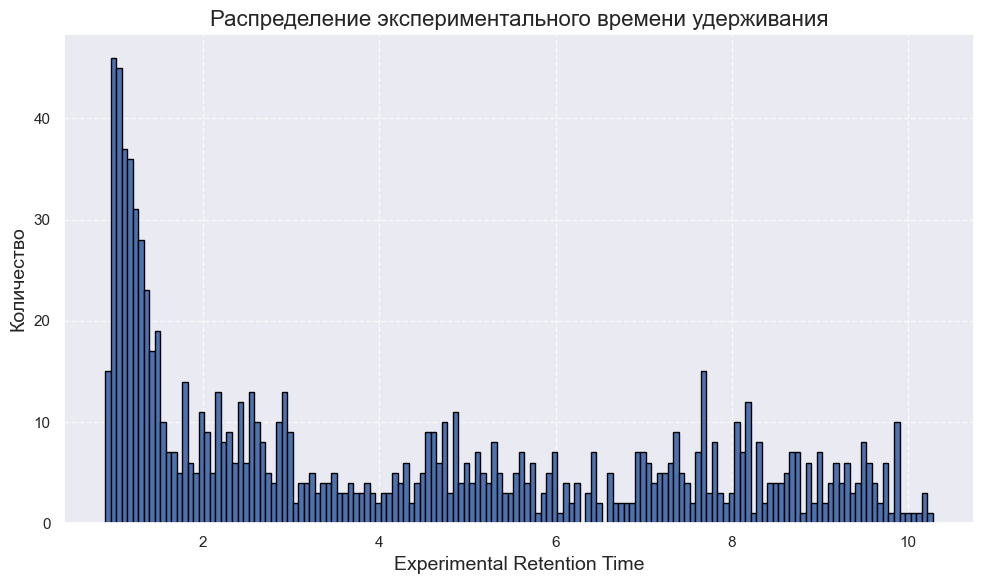

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))  # Размер графика
df['Experimental Retention Time'].hist(bins=150, edgecolor='black')  # Больше контролируем количество корзин и обводку
plt.title('Распределение экспериментального времени удерживания', fontsize=16)
plt.xlabel('Experimental Retention Time', fontsize=14)
plt.ylabel('Количество', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()  # Чтобы всё красиво влезло
plt.show()

In [11]:
print('Среднее:', df['Experimental Retention Time'].mean())
print('Медиана:', df['Experimental Retention Time'].median())
print('Стандартное отклонение:', df['Experimental Retention Time'].std())
print('Асимметрия:', df['Experimental Retention Time'].skew())
print('Эксцесс:', df['Experimental Retention Time'].kurtosis())

Среднее: 4.179323071847508
Медиана: 3.18395
Стандартное отклонение: 2.913692926861282
Асимметрия: 0.5157886416174192
Эксцесс: -1.1681955072653813


In [12]:
from scipy.stats import shapiro

stat, p = shapiro(df['Experimental Retention Time'])
print('Статистика теста = %.3f, p-значение = %.3f' % (stat, p))

if p > 0.05:
    print('Распределение похоже на нормальное (не отвергаем H0)')
else:
    print('Распределение не нормальное (отвергаем H0)')

Статистика теста = 0.881, p-значение = 0.000
Распределение не нормальное (отвергаем H0)


# Выделение необходимых данных

In [13]:
# Добавляем описания молекул в датасет
mol_list = []

for smile in df['SMILES']:
    mol = Chem.MolFromSmiles(smile)
    mol = Chem.AddHs(mol)
    mol_list.append(mol)

In [14]:
df['Mol'] = mol_list

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1023 entries, 0 to 1022
Data columns (total 4 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   NAME                         1023 non-null   object 
 1   SMILES                       1023 non-null   object 
 2   Experimental Retention Time  1023 non-null   float64
 3   Mol                          1023 non-null   object 
dtypes: float64(1), object(3)
memory usage: 32.1+ KB


In [16]:
df.head()

NAME  \
0  (2-oxo-2,3-dihydro-1H-indol-3-yl)acetic acid   
1             1,1-Dimethyl-4-phenylpiperazinium   
2                           1,2-Cyclohexanediol   
3                          1,2-Cyclohexanedione   
4                      1,3,7-Trimethyluric acid   

                            SMILES  Experimental Retention Time  \
0  C1=CC=C2C(=C1)C(C(=O)N2)CC(=O)O                     2.019083   
1        CC1C(NC(CN1)C2=CC=CC=C2)C                     2.607950   
2                   C1CCC(C(C1)O)O                     4.876550   
3                 C1CCC(=O)C(=O)C1                     5.772267   
4  CN1C2=C(NC1=O)N(C(=O)N(C2=O)C)C                     1.827733   

                                                 Mol  
0  <rdkit.Chem.rdchem.Mol object at 0x0000015A587...  
1  <rdkit.Chem.rdchem.Mol object at 0x0000015A587...  
2  <rdkit.Chem.rdchem.Mol object at 0x0000015A587...  
3  <rdkit.Chem.rdchem.Mol object at 0x0000015A587...  
4  <rdkit.Chem.rdchem.Mol object at 0x0000015A587...

In [17]:
calc = Calculator(descriptors, ignore_3D=False)
def generate_3d_coordinates(molecule):
    AllChem.EmbedMolecule(molecule)
    AllChem.MMFFOptimizeMolecule(molecule)

In [18]:
# Вычисление дескрипторов
descrs = []
for mol in tqdm(df['Mol']):
    # Выделение координат
    generate_3d_coordinates(mol)
    # Вычисление дескрипторов
    result = calc(mol)
    descrs.append(result)

100%|██████████| 1023/1023 [02:23<00:00,  7.15it/s]


In [19]:
# сolumns = [descriptor.get_name() for descriptor in calc.descriptors]
сolumns = [str(key) for key in descrs[-1].keys()]

final_df = df[['NAME', 'SMILES', 'Experimental Retention Time']]
final_df[сolumns] = pd.DataFrame(descrs)

In [20]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1023 entries, 0 to 1022
Columns: 1829 entries, NAME to mZagreb2
dtypes: bool(2), float64(965), int64(310), object(552)
memory usage: 14.3+ MB


Проверка, что выделение корректно: 3D-молекулы говорят о успешной оптимизации исходных SMILES.

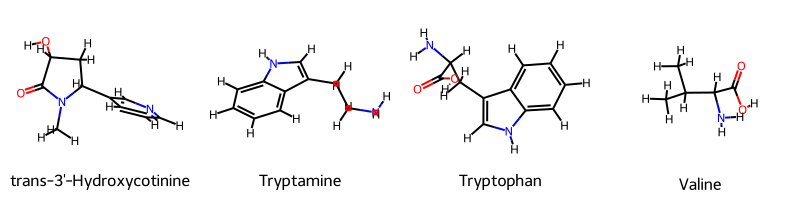

In [21]:
Draw.MolsToGridImage(df['Mol'][-4:],
                     molsPerRow=4,
                     subImgSize=(200,200),
                     legends=[x for x in df['NAME'][-4:]])

In [22]:
final_df.sample(n=5)

NAME  \
594                Picrotin   
69   3-Hydroxyphenylalanine   
393              Kaempferol   
255      Dexbrompheniramine   
529               Nobiletin   

                                                SMILES  \
594  CC12C3C4C(C(C1(CC5C2(O5)C(=O)O3)O)C(=O)O4)C(C)...   
69                 C1=CC(=CC(=C1)O)CC(C(=O)[O-])[NH3+]   
393      C1=CC(=CC=C1C2=C(C(=O)C3=C(C=C(C=C3O2)O)O)O)O   
255               CN(C)CCC(C1=CC=C(C=C1)Br)C2=CC=CC=N2   
529  COC1=C(C=C(C=C1)C2=CC(=O)C3=C(O2)C(=C(C(=C3OC)...   

     Experimental Retention Time  \
594                     1.214517   
69                      7.442133   
393                     1.399650   
255                     2.559600   
529                     1.003950   

                                                   ABC  \
594  module 'numpy' has no attribute 'float'.\n`np....   
69   module 'numpy' has no attribute 'float'.\n`np....   
393  module 'numpy' has no attribute 'float'.\n`np....   
255  module 'numpy' has no attribute 'float'.\n`np....   
529  module 'numpy' has no attribute 'float'.\n`np....   

                                                 ABCGG  nAcid  nBase  \
594  module 'numpy' has no attribute 'float'.\n`np....      0      0   
69   module 'numpy' has no attribute 'float'.\n`np....      1      1   
393  module 'numpy' has no attribute 'float'.\n`np....      0      0   
255  module 'numpy' has no attribute 'float'.\n`np....      0      1   
529  module 'numpy' has no attribute 'float'.\n`np....      0      0   

       SpAbs_A   SpMax_A  SpDiam_A  ...      SRW10     TSRW10          MW  \
594  27.798862  2.880472  5.467313  ...  11.085721  81.486762  310.105253   
69   15.279553  2.248876  4.497752  ...   9.045112  43.383210  181.073893   
393  26.497632  2.495257  4.990514  ...  10.156850  55.429507  286.047738   
255  24.221083  2.349628  4.699256  ...   9.572271  51.676805  318.073161   
529  37.560862  2.544429  5.088858  ...  10.472290  64.868094  402.131468   

          AMW  WPath  WPol  Zagreb1  Zagreb2   mZagreb1  mZagreb2  
594  7.752631    787    54    150.0    206.0   9.027778  4.152778  
69   7.544746    262    15     60.0     65.0   5.694444  2.944444  
393  9.227346    872    37    114.0    137.0   7.750000  4.500000  
255  8.370346    718    25     92.0    103.0   6.305556  4.305556  
529  7.884931   2106    56    150.0    184.0  10.972222  6.916667  

[5 rows x 1829 columns]

# Анализ данных (EDA)

In [23]:
obj = final_df.select_dtypes(include=['object', 'bool']).columns.drop(['NAME', 'SMILES'])
final_df[obj] = final_df[obj].astype('float')
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1023 entries, 0 to 1022
Columns: 1829 entries, NAME to mZagreb2
dtypes: float64(1517), int64(310), object(2)
memory usage: 14.3+ MB


Мы видим, что только 2 типа данных вида `object` остались в датафрейме. После анализа выяснилось, что `ABC` `ABCGG` дескрипторы незначимы (NaN). Отбросим их, а также `SMILES` и `NAME`

In [24]:
final_df_dropped = final_df.drop(['ABC', 'ABCGG','NAME','SMILES'], axis = 1)
final_df_dropped.T.head()

0          1         2         3     \
Experimental Retention Time   2.019083   2.607950  4.876550  5.772267   
nAcid                         1.000000   0.000000  0.000000  0.000000   
nBase                         0.000000   2.000000  0.000000  0.000000   
SpAbs_A                      17.506132  18.348875  9.953960  9.953960   
SpMax_A                       2.443585   2.335372  2.193527  2.193527   

                                  4         5          6         7     \
Experimental Retention Time   1.827733  1.473133   1.560217  1.151700   
nAcid                         0.000000  0.000000   2.000000  0.000000   
nBase                         0.000000  0.000000   0.000000  0.000000   
SpAbs_A                      18.656999  9.431148  14.383377  9.924777   
SpMax_A                       2.528281  2.175328   2.278414  2.170086   

                                  8         9     ...       1013       1014  \
Experimental Retention Time   4.090533  1.368133  ...   6.980000   7.100000   
nAcid                         0.000000  0.000000  ...   0.000000   1.000000   
nBase                         0.000000  0.000000  ...   3.000000   1.000000   
SpAbs_A                      17.217679  9.674988  ...  12.053348  11.356193   
SpMax_A                       2.496396  2.210509  ...   1.918986   2.389175   

                                  1015       1016      1017       1018  \
Experimental Retention Time   2.960000   9.220000  7.850000   8.560000   
nAcid                         1.000000   1.000000  1.000000   1.000000   
nBase                         1.000000   4.000000  1.000000   1.000000   
SpAbs_A                      34.740128  15.123934  6.720566  14.256519   
SpMax_A                       2.246068   2.102783  2.101003   2.226195   

                                  1019       1020       1021      1022  
Experimental Retention Time   2.020000   6.920000   6.920000  7.240000  
nAcid                         0.000000   0.000000   1.000000  1.000000  
nBase                         0.000000   1.000000   1.000000  1.000000  
SpAbs_A                      18.211815  15.894371  19.078473  8.424292  
SpMax_A                       2.423215   2.393832   2.406349  2.135779  

[5 rows x 1023 columns]

In [25]:
final_df_dropped.to_csv('HILIC_dataset_descriptors.csv', index=False)

In [26]:
!zip HILIC_dataset_descriptors.zip HILIC_dataset_descriptors.csv

"zip" �� ���� ����७��� ��� ���譥�
��������, �ᯮ��塞�� �ணࠬ��� ��� ������ 䠩���.


In [27]:
# Вычисляем корреляционную матрицу
corr_matrix = final_df_dropped.corr()

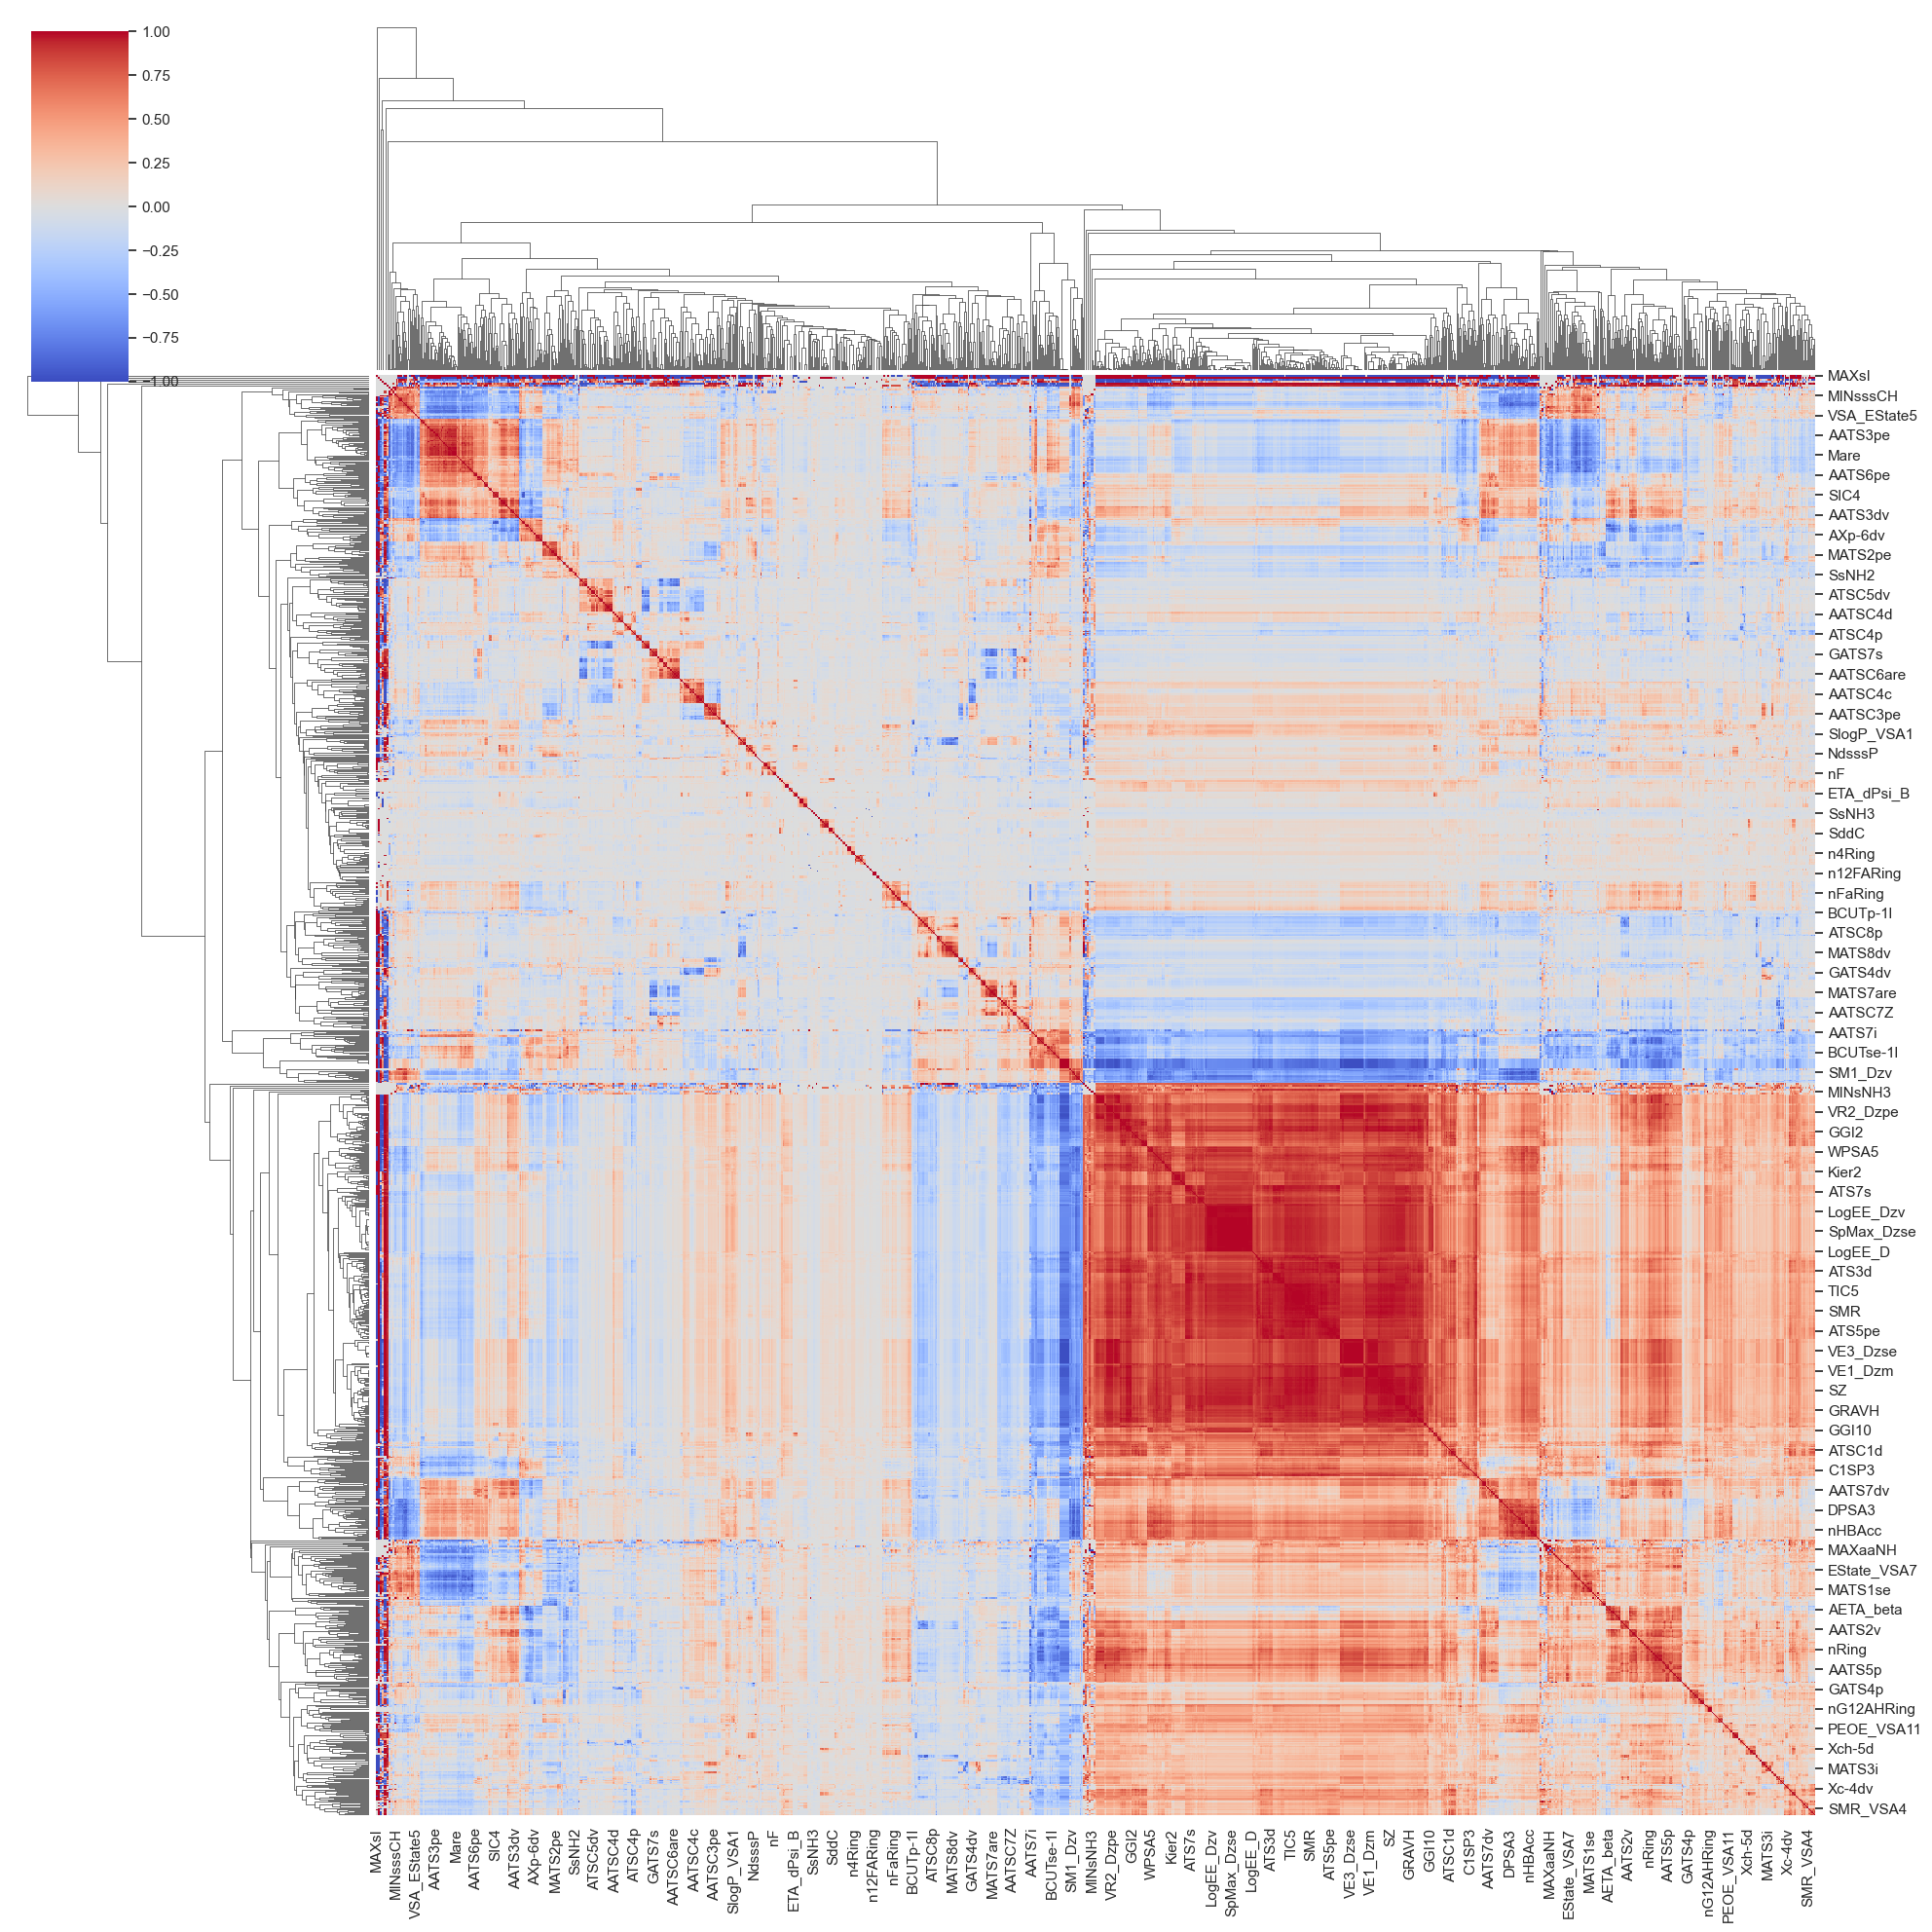

In [28]:
# Удаляем столбцы и строки, где все NaN
corr_matrix_cleaned = corr_matrix.dropna(axis=0, how='all').dropna(axis=1, how='all')

# И заполняем оставшиеся NaN нулями
corr_matrix_cleaned = corr_matrix_cleaned.fillna(0)

sns.clustermap(corr_matrix_cleaned, figsize=(20, 20), cmap='coolwarm', center=0)

# Построение моделей

Здесь мы перезапускаем среду выполнения для избежания переполнения ОЗУ.

Можно чистить переменные и временные файлы, но проще просто перезапустить

## Создание данных

In [29]:
# Базовые библиотеки
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# sklearn
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Модели бустинга
import lightgbm as lgb
import xgboost as xgb
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

# Дополнительные библиотеки
import shap
from tqdm import tqdm

In [30]:
import warnings
warnings.filterwarnings('ignore')

In [31]:
df = pd.read_csv('HILIC_dataset_descriptors.csv')

In [32]:
df.head()

Experimental Retention Time  nAcid  nBase    SpAbs_A   SpMax_A  SpDiam_A  \
0                     2.019083      1      0  17.506132  2.443585  4.706389   
1                     2.607950      0      2  18.348875  2.335372  4.670745   
2                     4.876550      0      0   9.953960  2.193527  4.387054   
3                     5.772267      0      0   9.953960  2.193527  4.387054   
4                     1.827733      0      0  18.656999  2.528281  4.956577   

      SpAD_A   SpMAD_A   LogEE_A     VE1_A  ...     SRW10     TSRW10  \
0  17.506132  1.250438  3.573622  3.331353  ...  9.497097  60.030351   
1  18.348875  1.310634  3.564716  3.500479  ...  9.398561  45.522055   
2   9.953960  1.244245  2.980241  2.721913  ...  8.555837  35.908899   
3   9.953960  1.244245  2.980241  2.721913  ...  8.555837  35.908899   
4  18.656999  1.243800  3.653695  3.544886  ...  9.922456  62.252387   

           MW       AMW  WPath  WPol  Zagreb1  Zagreb2  mZagreb1  mZagreb2  
0  191.058243  8.306880    287    19     72.0     84.0  5.055556  3.083333  
1  190.146999  5.942094    303    19     70.0     80.0  4.444444  3.138889  
2  116.083730  5.804186     60     8     36.0     39.0  3.222222  1.861111  
3  112.052429  7.003277     60     8     36.0     39.0  3.222222  1.861111  
4  210.075290  8.403012    312    28     82.0    102.0  7.138889  3.222222  

[5 rows x 1825 columns]

In [33]:
df = df.drop(['ABC', 'ABCGG','NAME','SMILES'], axis = 1, errors='ignore')  # Заново удалим столбцы
df = df.fillna(0)  # Заполним пропуски нулями

In [34]:
# Разделяем данные
X = df.drop('Experimental Retention Time', axis=1)
y = df['Experimental Retention Time']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape, X_test.shape

((818, 1824), (205, 1824))

In [35]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled).fillna(0).to_numpy()
X_test_scaled = pd.DataFrame(X_test_scaled).fillna(0).to_numpy()

In [36]:
# Здесь будут храниться результаты обучения моделей
results = {}

## Необходимые функции

In [37]:
def print_metrics(metrics: dict):
    """
    печатает метрики модели

    metrics (dict): словарь вида {'MAE': ..., 'RMSE': ..., 'R2': ...}
    """
    print('-' * 40)
    print(f"{'Метрика':<10} | {'Значение':>10}")
    print('-' * 40)
    for key, value in metrics.items():
        print(f"{key:<10} | {value:>10.4f}")
    print('-' * 40)

In [38]:
def evaluate_model(model, X_test, y_test) -> dict:
    """Считает MAE, RMSE и R2 для модели"""
    y_pred = model.predict(X_test)
    return {
        'MAE': mean_absolute_error(y_test, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
        'R2': r2_score(y_test, y_pred)
    }, y_pred

In [39]:
def plot_real_vs_pred(y_true, y_pred, color, metrics: dict, model_name='Модель'):
    plt.figure(figsize=(6, 6))
    plt.scatter(y_true, y_pred, alpha=0.5, c = color)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'k--', lw=2)
    plt.xlabel('Реальное')
    plt.ylabel('Предсказанное')
    plt.title(f'{model_name}\nMAE: {metrics["MAE"]:.2f}, RMSE: {metrics["RMSE"]:.2f}, $R^2$: {metrics["R2"]:.2f}')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

## Baseline

In [40]:
model = LinearRegression()
model.fit(X_train_scaled, y_train)
results['LinearRegression'], y_pred = evaluate_model(model, X_test_scaled, y_test)
print_metrics(results['LinearRegression'])

----------------------------------------
Метрика    |   Значение
----------------------------------------
MAE        |     5.1374
RMSE       |     7.3928
R2         |    -5.6074
----------------------------------------


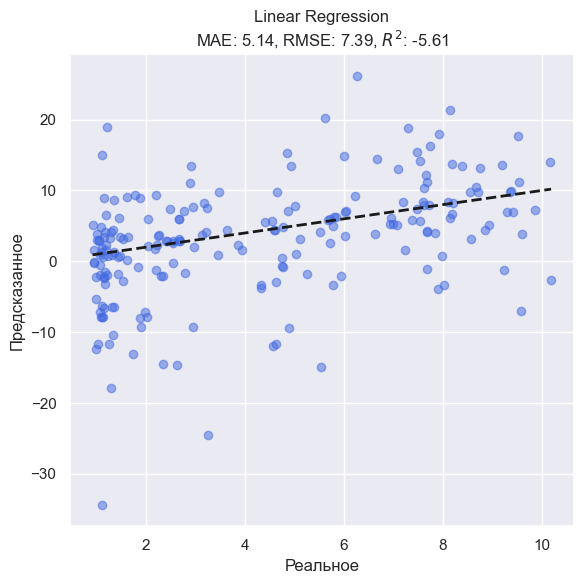

In [41]:
plot_real_vs_pred(y_test, y_pred, 'royalblue', results['LinearRegression'], 'Linear Regression')

У модели очень плохие результаты, метрики указывают на то, что модель хуже, чем простое предсказание среднего значения


Линейная регрессия в данном случае не способна уловить структуру данных, предсказания практически бесполезны

## Другие методы

### Random Forest

In [42]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train_scaled, y_train)
results['RandomForest'], y_pred = evaluate_model(rf_model, X_test_scaled, y_test)
print_metrics(results['RandomForest'])

----------------------------------------
Метрика    |   Значение
----------------------------------------
MAE        |     1.0255
RMSE       |     1.5214
R2         |     0.7202
----------------------------------------


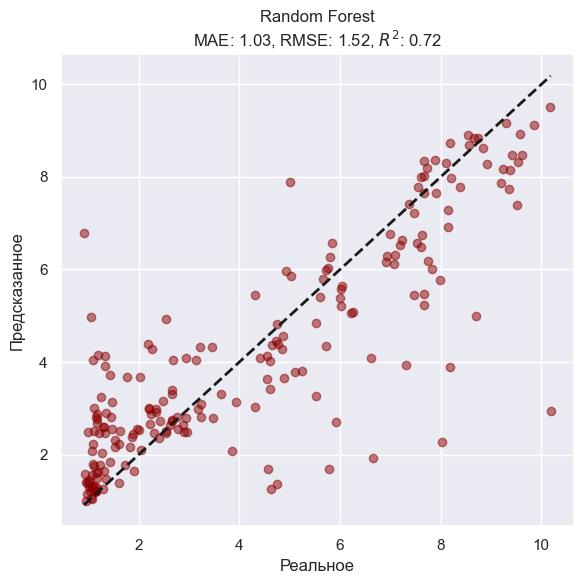

In [43]:
plot_real_vs_pred(y_test, y_pred, '#8B0000', results['RandomForest'], 'Random Forest')

### HistGradientBoosting

In [44]:
hgb_model = HistGradientBoostingRegressor(random_state=42)
hgb_model.fit(X_train_scaled, y_train)
results['HistGradientBoosting'], y_pred = evaluate_model(rf_model, X_test_scaled, y_test)

In [45]:
print_metrics(results['HistGradientBoosting'])

----------------------------------------
Метрика    |   Значение
----------------------------------------
MAE        |     1.0255
RMSE       |     1.5214
R2         |     0.7202
----------------------------------------


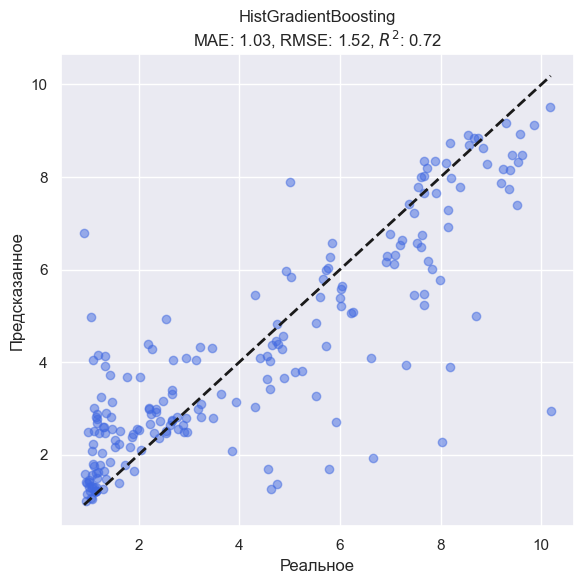

In [46]:
plot_real_vs_pred(y_test, y_pred, 'royalblue', results['HistGradientBoosting'], 'HistGradientBoosting')

### XGBoost

In [47]:
xgb_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1,
                             random_state=42, n_jobs=-1)
xgb_model.fit(X_train_scaled, y_train)
results['XGBoost'], y_pred = evaluate_model(xgb_model, X_test_scaled, y_test)

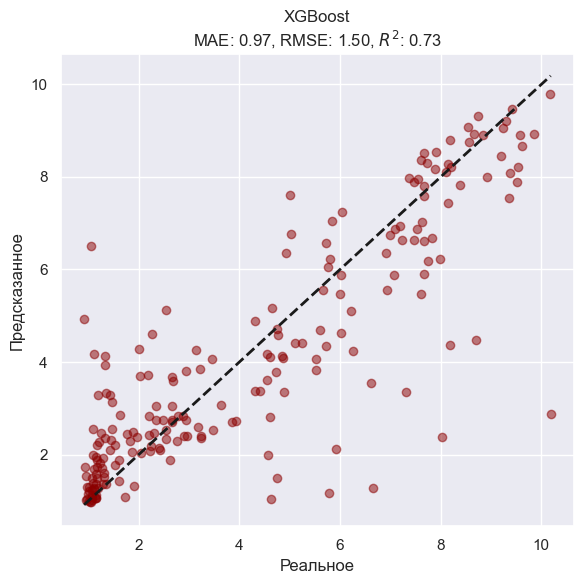

In [48]:
plot_real_vs_pred(y_test, y_pred, '#8B0000', results['XGBoost'], 'XGBoost')

### LightGBM

In [49]:
lgb_model = lgb.LGBMRegressor(n_estimators=100, learning_rate=0.1, random_state=42,
                              n_jobs=-1, verbose=-1)
lgb_model.fit(X_train_scaled, y_train)
results['LightGBM'], y_pred = evaluate_model(lgb_model, X_test_scaled, y_test)

In [50]:
print_metrics(results['LightGBM'])

----------------------------------------
Метрика    |   Значение
----------------------------------------
MAE        |     0.9238
RMSE       |     1.4371
R2         |     0.7503
----------------------------------------


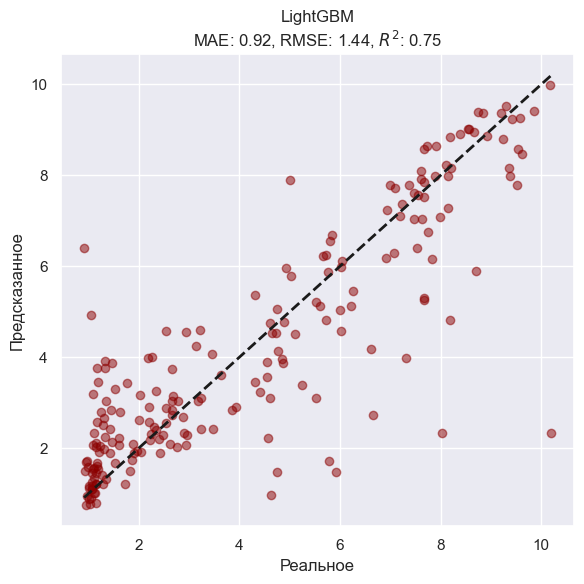

In [51]:
plot_real_vs_pred(y_test, y_pred, '#8B0000', results['LightGBM'], 'LightGBM')

In [52]:
pd.DataFrame(results).T.columns

Index(['MAE', 'RMSE', 'R2'], dtype='object')

In [53]:
results_df = pd.DataFrame(results).sort_values('R2', axis=1, ascending=False).T.round(2)
results_df

MAE  RMSE    R2
LightGBM              0.92  1.44  0.75
XGBoost               0.97  1.50  0.73
RandomForest          1.03  1.52  0.72
HistGradientBoosting  1.03  1.52  0.72
LinearRegression      5.14  7.39 -5.61

На основании данной таблицы можно сделать вывод, что ТОП-3 моделями являются LGBM, RandomForest и XGBoost (за счет чуть более меньшего MAE). Проведем дальнейшее исследование с ними.

## Улучшения

### Перебор параметров

Попробуем перебрать параметры с целью проверки улучшения результатов работы моделей

----------------------------------------
Метрика    |   Значение
----------------------------------------
MAE        |     0.9503
RMSE       |     1.4505
R2         |     0.7456
----------------------------------------


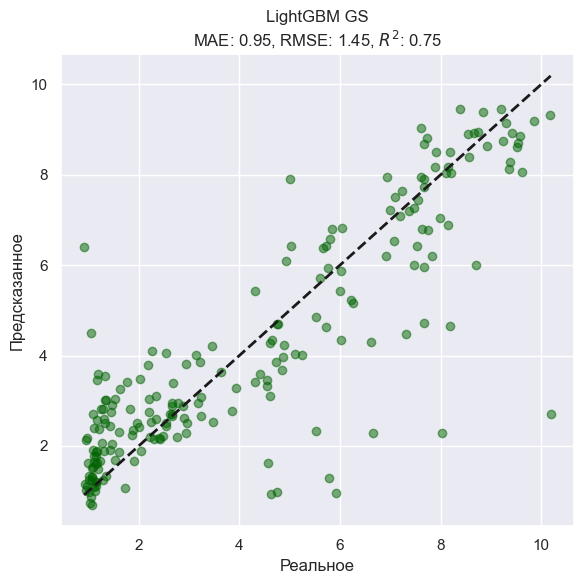

In [54]:
# LightGBM
lgb_params = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5, 7]
}
lgb_model = GridSearchCV(lgb.LGBMRegressor(random_state=42, n_jobs=-1, verbose=-1),
                         lgb_params, cv=3, scoring='neg_root_mean_squared_error', n_jobs=-1)
lgb_model.fit(X_train_scaled, y_train)
best_lgb = lgb_model.best_estimator_
results['LightGBM GS'], y_pred = evaluate_model(best_lgb, X_test_scaled, y_test)
print_metrics(results['LightGBM GS'])
plot_real_vs_pred(y_test, y_pred,'darkgreen', results['LightGBM GS'], 'LightGBM GS')

In [55]:
print(best_lgb.get_params())

{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': 5, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 200, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': 42, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'verbose': -1}


----------------------------------------
Метрика    |   Значение
----------------------------------------
MAE        |     1.0224
RMSE       |     1.5098
R2         |     0.7244
----------------------------------------


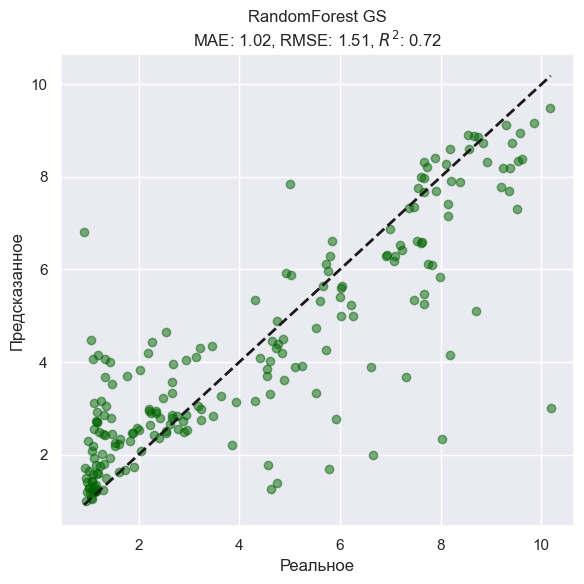

In [56]:
# RandomForest
rf_params = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}
rf_model = GridSearchCV(RandomForestRegressor(random_state=42, n_jobs=-1),
                        rf_params, cv=3, scoring='neg_root_mean_squared_error', n_jobs=-1)
rf_model.fit(X_train_scaled, y_train)
best_rf = rf_model.best_estimator_
results['RandomForest GS'], y_pred = evaluate_model(best_rf, X_test_scaled, y_test)
print_metrics(results['RandomForest GS'])
plot_real_vs_pred(y_test, y_pred,'darkgreen', results['RandomForest GS'], 'RandomForest GS')

In [57]:
print(best_rf.get_params())

{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 20, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 200, 'n_jobs': -1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}


----------------------------------------
Метрика    |   Значение
----------------------------------------
MAE        |     0.9276
RMSE       |     1.4610
R2         |     0.7419
----------------------------------------


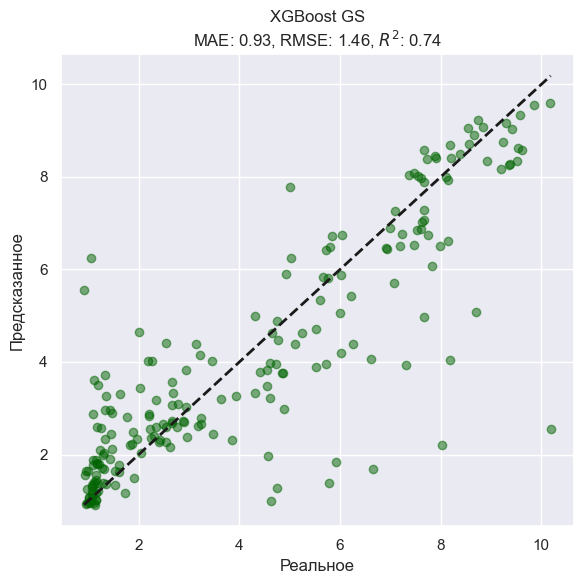

In [58]:
# XGBoost
xgb_params = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5, 7]
}
xgb_model = GridSearchCV(XGBRegressor(random_state=42, n_jobs=-1, verbosity=0),
                         xgb_params, cv=3, scoring='neg_root_mean_squared_error', n_jobs=-1)
xgb_model.fit(X_train_scaled, y_train)
best_xgb = xgb_model.best_estimator_
results['XGBoost GS'], y_pred = evaluate_model(best_xgb, X_test_scaled, y_test)
print_metrics(results['XGBoost GS'])
plot_real_vs_pred(y_test, y_pred, 'darkgreen', results['XGBoost GS'], 'XGBoost GS')

In [59]:
print(best_xgb.get_params())

{'objective': 'reg:squarederror', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'feature_weights': None, 'gamma': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.05, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 5, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': 200, 'n_jobs': -1, 'num_parallel_tree': None, 'random_state': 42, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': None, 'tree_method': None, 'validate_parameters': None, 'verbosity': 0}


In [60]:
results_df = pd.DataFrame(results).sort_values('R2', axis=1, ascending=False).T.round(2)
results_df

MAE  RMSE    R2
LightGBM              0.92  1.44  0.75
LightGBM GS           0.95  1.45  0.75
XGBoost GS            0.93  1.46  0.74
XGBoost               0.97  1.50  0.73
RandomForest GS       1.02  1.51  0.72
RandomForest          1.03  1.52  0.72
HistGradientBoosting  1.03  1.52  0.72
LinearRegression      5.14  7.39 -5.61

### Важность признаков

In [61]:
# 1. Обучаем каждую модель отдельно
lgb_model = LGBMRegressor(random_state=42, n_jobs=-1)
lgb_model.fit(X_train, y_train)

xgb_model = XGBRegressor(random_state=42, n_jobs=-1, verbosity=0)
xgb_model.fit(X_train, y_train)

rf_model = RandomForestRegressor(random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)

# 2. Считаем SHAP для каждой модели
lgb_explainer = shap.Explainer(lgb_model, X_train)
lgb_shap_values = lgb_explainer(X_test, check_additivity=False)

xgb_explainer = shap.Explainer(xgb_model, X_train)
xgb_shap_values = xgb_explainer(X_test, check_additivity=False)

rf_explainer = shap.Explainer(rf_model, X_train)
rf_shap_values = rf_explainer(X_test, check_additivity=False)

# 3. Создаём датафреймы важностей
lgb_importance_df = pd.DataFrame({
    'feature': X_test.columns,
    'importance': np.abs(lgb_shap_values.values).mean(axis=0),
    'model': 'LightGBM'
})

xgb_importance_df = pd.DataFrame({
    'feature': X_test.columns,
    'importance': np.abs(xgb_shap_values.values).mean(axis=0),
    'model': 'XGBoost'
})

rf_importance_df = pd.DataFrame({
    'feature': X_test.columns,
    'importance': np.abs(rf_shap_values.values).mean(axis=0),
    'model': 'RandomForest'
})

# 4. Объединяем все важности в один датафрейм
full_importance_df = pd.concat([lgb_importance_df, xgb_importance_df, rf_importance_df]).reset_index(drop=True)

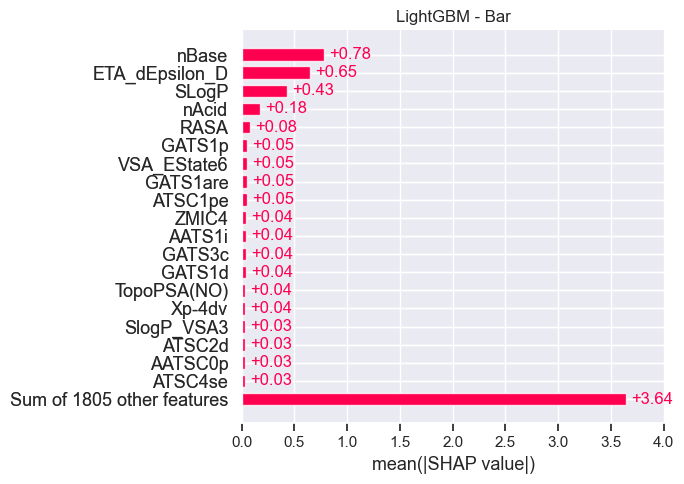

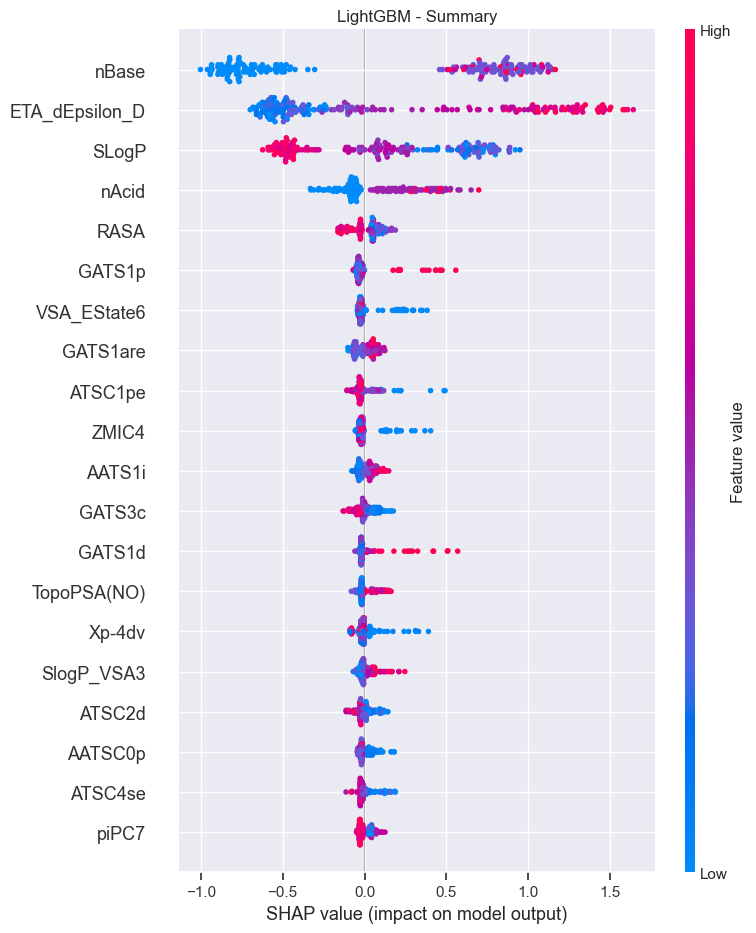

In [62]:
# 5. Строим графики для каждой модели
# LightGBM
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
shap.plots.bar(lgb_shap_values, max_display=20, show=False, ax=ax)
ax.set_title('LightGBM - Bar')
plt.tight_layout()
plt.show()

shap.summary_plot(lgb_shap_values.values, X_test, show=False, plot_type="dot")
plt.title('LightGBM - Summary')
plt.tight_layout()
plt.show()


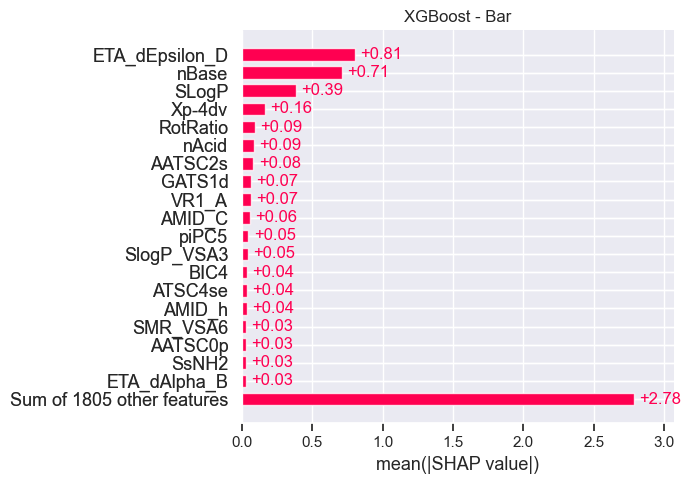

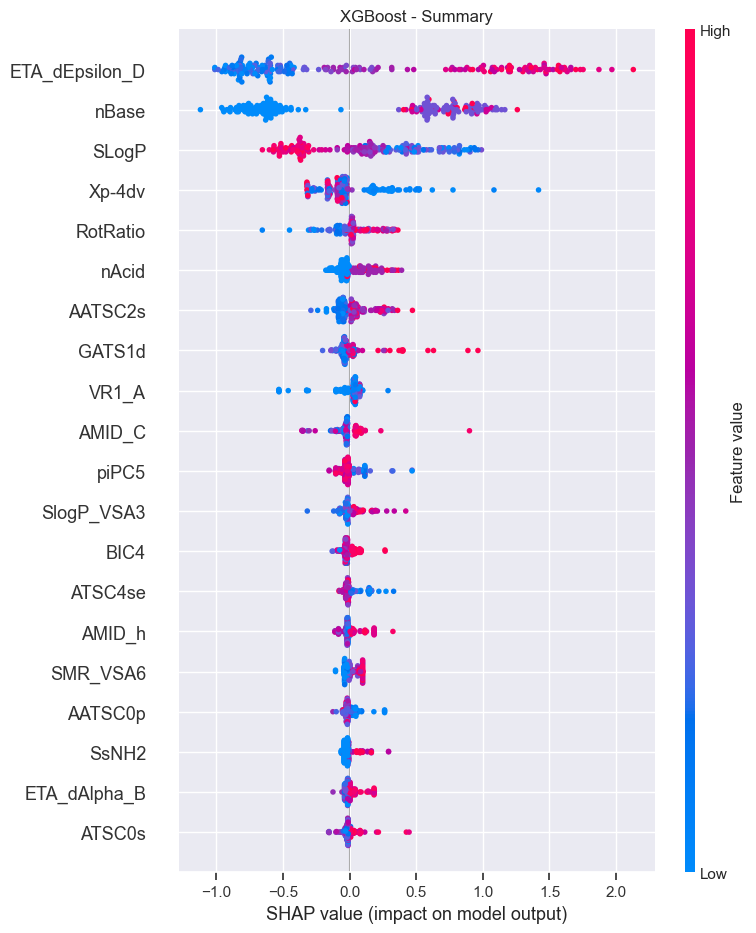

In [63]:
# XGBoost
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
shap.plots.bar(xgb_shap_values, max_display=20, show=False, ax=ax)
ax.set_title('XGBoost - Bar')
plt.tight_layout()
plt.show()

shap.summary_plot(xgb_shap_values.values, X_test, show=False, plot_type="dot")
plt.title('XGBoost - Summary')
plt.tight_layout()
plt.show()

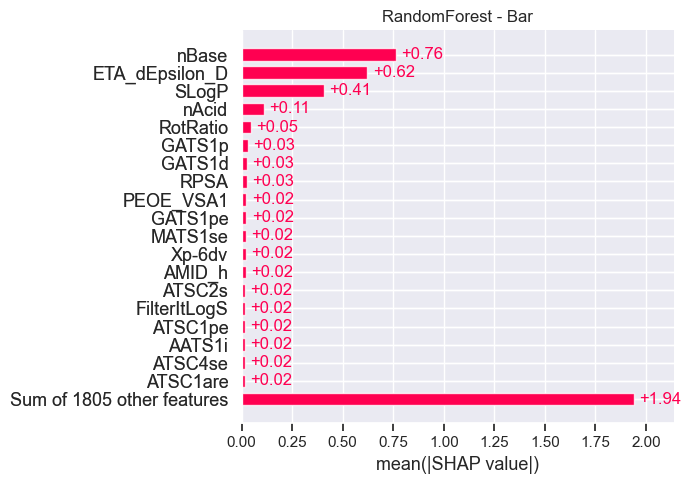

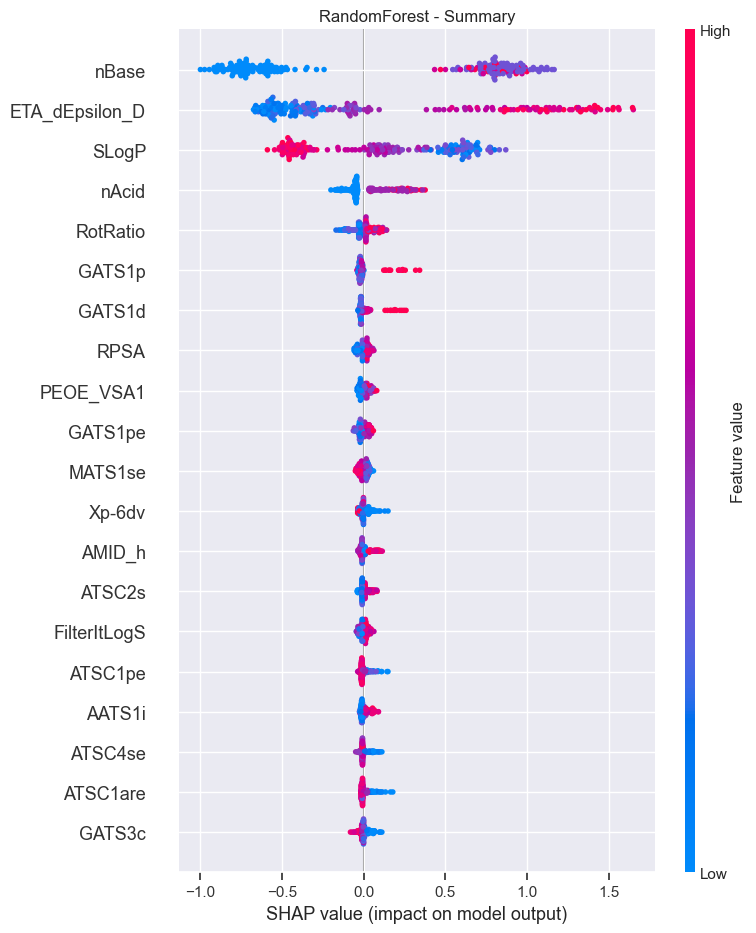

In [64]:
# RandomForest
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
shap.plots.bar(rf_shap_values, max_display=20, show=False, ax=ax)
ax.set_title('RandomForest - Bar')
plt.tight_layout()
plt.show()

shap.summary_plot(rf_shap_values.values, X_test, show=False, plot_type="dot")
plt.title('RandomForest - Summary')
plt.tight_layout()
plt.show()

Возьмем важные признаки для лучшей модели и посмотрим на качество

In [65]:
lgb_importance_df['cumulative_importance'] = lgb_importance_df['importance'].cumsum() / lgb_importance_df['importance'].sum()

# Сколько признаков нужно для 95% важности
n_features_95 = (lgb_importance_df['cumulative_importance'] <= 0.95).sum()

print(f'Нужно {n_features_95} признаков для покрытия 95% общей важности')

Нужно 1764 признаков для покрытия 95% общей важности


In [66]:
scores = []
features_range = range(10, n_features_95, 30)

for n in tqdm(features_range):
    top_n_features = lgb_importance_df.head(n)['feature'].tolist()
    X_train_n = X_train[top_n_features]
    scaler = StandardScaler()
    X_train_n = scaler.fit_transform(X_train_n)
    model = LGBMRegressor(random_state=42, n_jobs=-1)
    cv_score = cross_val_score(model, X_train_n, y_train, cv=3, scoring='r2', n_jobs=-1).mean()
    scores.append(cv_score)

  0%|          | 0/59 [00:00<?, ?it/s]

100%|██████████| 59/59 [01:54<00:00,  1.93s/it]


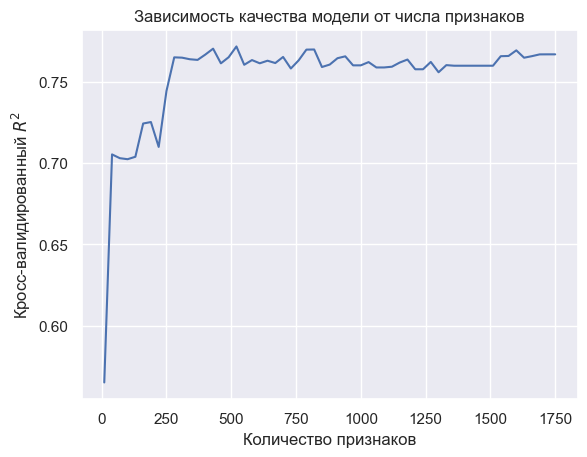

In [67]:
plt.plot(features_range, scores)
plt.xlabel('Количество признаков')
plt.ylabel('Кросс-валидированный $R^2$')
plt.title('Зависимость качества модели от числа признаков')
plt.grid(True)
plt.show()

Значение коэффициента детерминации на кросс-валидации сопостовимо с коэффициентом на обычной модели. Можно сделать вывод о том, что переобучения нет. Также стоит отметить, что случайный лес показал примерно такие же результаты, что и бустинговые методы, которые нечувствительны к переобучению. 

In [68]:
features_range

range(10, 1764, 30)

In [69]:
# Преобразуем в массив на всякий случай
features_range = list(features_range)
scores = list(scores)

# Находим индекс максимального R2
best_idx = int(np.argmax(scores))

# Получаем количество признаков и лучший R2
best_n = features_range[best_idx]
best_r2 = scores[best_idx]

print(f'Лучший результат: R2 = {best_r2:.4f} при {best_n} признаках')

Лучший результат: R2 = 0.7719 при 520 признаках


# Дополнение: Ridge-Regression

In [70]:
import sympy as sp
import pprint
from sklearn.linear_model import Ridge

In [71]:
ridge = Ridge(alpha = 1.0)
X5 = df[['nBase', 'nAcid', 'ETA_dEpsilon_D', 'GATS1d', 'RotRatio']]
desc_list = ['nBase', 'nAcid', 'ETA_dEpsilon_D', 'GATS1d', 'RotRatio']
X5_train, X5_test, y_train, y_test = train_test_split(X5, y, test_size=0.2, random_state=42)
ridge.fit(X5_train, y_train)
results['Ridge'], y_pred = evaluate_model(ridge, X5_test, y_test)
print_metrics(results['Ridge'])

----------------------------------------
Метрика    |   Значение
----------------------------------------
MAE        |     1.5069
RMSE       |     1.8797
R2         |     0.5728
----------------------------------------


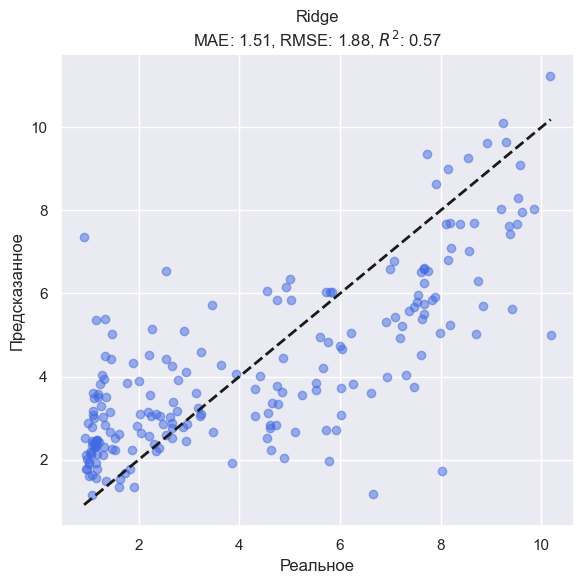

In [72]:
plot_real_vs_pred(y_test, y_pred, 'royalblue', results['Ridge'], 'Ridge')

In [ ]:
descriptors = sp.symbols(desc_list)
y_sym = sp.Symbol('y')


equation = ridge.intercept_
for coef, desc in zip(ridge.coef_, descriptors):
    equation += coef * desc
print('Уравнение регрессии:')
print(f'RT = {equation.evalf(n=3)}')

Уравнение регрессии:
RT = 12.8*ETA_dEpsilon_D + 1.61*GATS1d - 0.102*RotRatio + 1.25*nAcid + 0.949*nBase + 0.268


: 

# Выводы

* Лучшая модель по текущим метрикам — LightGBM ($MAE = 0.92, RMSE = 1.43, R^2= 0.75$)

* Параметрический перебор (GridSearch) не дал улучшений для лучшей модели

* LightGBM GS показал чуть более плохой результат после подбора гиперпараметров, чем базовый LightGBM

* Перебор количества признаков по SHAP важности показал, что максимальное качество достигается при 520 дескрипторах — $R^2 = 0.7720$

* Это улучшение на ~2.9% относительно базового $(R^2 : 0.75 \rightarrow 0.7720)$, что говорит о существенном вкладе отбора дескрипторов

* Удаление неинформативных признаков позволило повысить обобщающую способность модели без потери важной информации

* Выведено уравнение для Ridge-регрессии:

 $$RT = 12.8 \cdot \mathrm{ETA\_dEpsilon\_D} + 1.61 \cdot \mathrm{GATS1d} - 0.102 \cdot \mathrm{RotRatio} + 1.25 \cdot n\mathrm{Acid} + 0.949 \cdot n\mathrm{Base} + 0.268$$

* Полученные дескрипторы `nBase` и `nAcid` говорят о чрезвычайном влиянии кислотно-основных свойств на удерживание. Для более тонкой настройки и повышения точности модели можно использовать показатель кислотности аналита ($pK_{a}$) и изменение pH подвижной фазы

* Самыми весомым дескриптором являются `Eta_dEpsilon_D` и `GATS1d`. С их описанием вы можете ознакомиться ниже или в [документации](https://mordred-descriptor.github.io/documentation/master/descriptors.html) для mordred descriptors: 

## Дескриптор **ETA_dEpsilon_D** 

#### Формулы для **EtaEpsilon**

##### Для типов 1–4:
$$
\epsilon_i = \frac{\epsilon_i^{\text{raw}}}{N_i}, \quad i \leq 4
$$
- **$\epsilon_i^{\text{raw}}$** — суммарный вклад атомов типа $i$,
- **$N_i$** — количество атомов типа $i$.

##### Для типа 5 (XH-водороды):
$$
\epsilon_5 = \frac{\epsilon_2 + \epsilon_{XH}}{N_2 + N_{XH}}
$$
- **$\epsilon_2$** — значение EtaEpsilon для тяжелых атомов (тип 2),
- **$\epsilon_{XH}$** — вклад водородов, связанных с гетероатомами,
- **$N_2$** — количество тяжелых атомов,
- **$N_{XH}$** — количество XH-водородов.

---

#### Типы атомов для EtaEpsilon

| Тип | Описание                                                                 |
|-----|-------------------------------------------------------------------------|
| 1   | Все атомы молекулы (включая водороды).                                  |
| 2   | Только тяжелые атомы (C, O, N, S и др.).                                |
| 3   | Атомы эталонного алкана (модельной структуры).                          |
| 4   | Атомы насыщенного углеродного скелета (без двойных/тройных связей).     |
| XH  | Водороды, связанные с гетероатомами (O, N, S).                          |

---

#### Формула для **ETA_dEpsilon_D**
$$
\text{ETA\_dEpsilon\_D} = \epsilon_2 - \epsilon_5
$$
где:
- **$\epsilon_2$** — средняя электронная плотность тяжелых атомов,
- **$\epsilon_5$** — комбинированный параметр для тяжелых атомов и XH-водородов.

---

#### **Выводы о значимости ETA_dEpsilon_D в HILIC**

1. *Полярные взаимодействия*:  
   Высокое значение $\epsilon_2$ указывает на обилие тяжелых атомов (O, N), которые усиливают гидрофильные взаимодействия с фазой.

2. *Роль XH-водородов*:  
   Низкое $\epsilon_5$ увеличивает градиент $\epsilon_2 - \epsilon_5$, что коррелирует с сильным удерживанием.

3. *Структурные индикаторы*:  
   - Молекулы с **-OH**, **-NH₂** в позиции 2 и неполярными группами в позиции 5 будут иметь высокий ETA_dEpsilon_D.  
   - Молекулы с равномерным распределением электронной плотности (например, сахара) покажут меньшие значения.

## Дескриптор **GATS1d** (Geary Autocorrelation - lag 1)

#### Формулы 

Дескриптор рассчитывается по формуле автокорреляции Геари для соседних атомов (lag=1):

$$
GATS1d = \frac{(N-1) \sum_{i,j} w_{ij}(p_i - p_j)^2}{2W \sum_{i} (p_i - \bar{p})^2}
$$

где:
- **N** - общее число атомов в молекуле
- **pᵢ** - атомное свойство (по умолчанию - атомная масса)
- **wᵢⱼ** = 1 если атомы i и j связаны непосредственно, иначе 0
- **W** - общее число непосредственно связанных пар атомов
- **p̄** - среднее значение атомного свойства

#### **Выводы о значимости GATS1d в HILIC**

   Высокое значение GATS1d указывает на резкие различия в атомных свойствах между **соседними атомами**.  
   Молекулы с высоким GAТS1d, например, содержиащие C-O связь демонстрируют повышенное удерживание из-за образования стабильных водородных связей и диполь-дипольных взаимодействий.


